In [27]:
from PIL import Image
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import add, Conv2D, BatchNormalization, PReLU, \
    UpSampling2D, Input, LeakyReLU, Flatten, Dense
from tensorflow.keras import Model, Sequential
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

In [42]:
DIRNAME = "../input/mscoco/mscoco_resized/train2014"
CHECKPOINT_DIR = "./training_checkpoints"
MODELS_DIR = "../input/input-models/"
SHOULD_LOAD_MODELS = False

PIXELS_RESIZE = 64
PIXELS_SIZE = 256
GEN_INPUT = (None, None, 3)

TRAIN_SIZE = 2000
TEST_SIZE = 20

EPOCHS = 20
EPOCHS_PER_IMAGE_BATCH = 20
TOTAL_TRAIN_SIZE = int(EPOCHS / EPOCHS_PER_IMAGE_BATCH * TRAIN_SIZE)

LEARNING_RATE = 1e-4
BETA_1 = 0.9

In [5]:
normalize = lambda img: (img / 127.5) - 1
denormalize = lambda img: tf.clip_by_value((img + 1) * 127.5, 0, 255)

def convert_data(data, size):
    arr = np.array(data, dtype='float32')
    arr = normalize(arr)
    return arr.reshape(-1, 1, *size, 3)

def load_imgs():
    X, Y = list(), list()
    c = 0
    for filename in tqdm(os.listdir(DIRNAME)):
        im = Image.open(os.path.join(DIRNAME, filename))
        Y.append(np.array(im))
        im = im.resize((PIXELS_RESIZE, PIXELS_RESIZE))
        X.append(np.array(im))
        c += 1
        if c == TOTAL_TRAIN_SIZE + TEST_SIZE: break
    return (X, Y)

In [11]:
X, Y = load_imgs()

  2%|▏         | 2019/82783 [00:07<04:56, 272.49it/s]


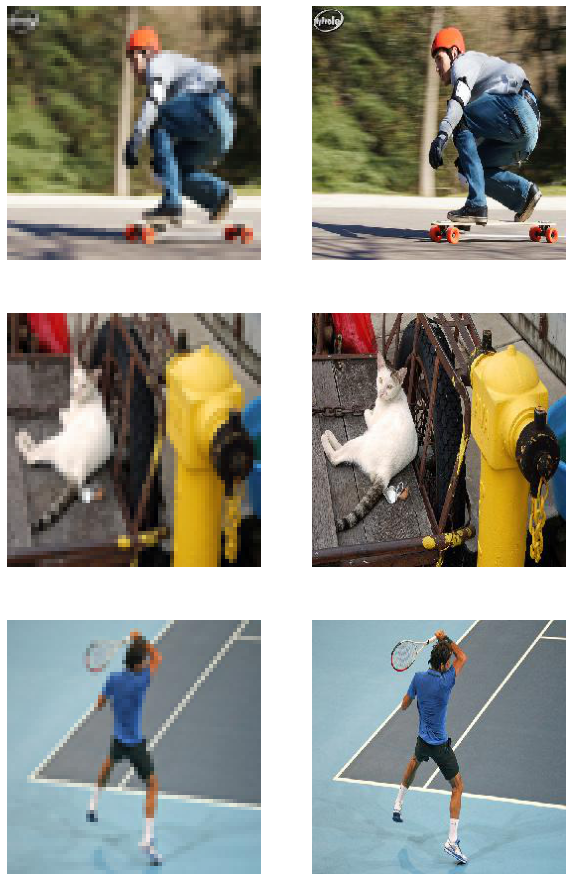

In [35]:
to_display = 3
fig, axes = plt.subplots(to_display, 2, figsize=(10, 16))
for i in range(to_display):
    idx = randrange(0, TRAIN_SIZE)
    axes[i][0].imshow(X[idx])
    axes[i][1].imshow(Y[idx])
    for ax in axes[i]: ax.axis('off')
plt.show()

In [36]:
X = convert_data(X, (PIXELS_RESIZE, PIXELS_RESIZE))
Y = convert_data(Y, (PIXELS_SIZE, PIXELS_SIZE))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, train_size=TOTAL_TRAIN_SIZE)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2000, 1, 64, 64, 3)
(2000, 1, 256, 256, 3)
(20, 1, 64, 64, 3)
(20, 1, 256, 256, 3)


In [43]:
def residual_sub_block(input_layer):
    sub_block = Conv2D(64, (3,3), padding="same")(input_layer)
    return BatchNormalization(momentum = 0.5)(sub_block)

def residual_block(input_layer):
    residual_layers = residual_sub_block(input_layer)
    residual_layers = PReLU(shared_axes = [1,2])(residual_layers)
    residual_layers = residual_sub_block(residual_layers)
    return add([input_layer, residual_layers])

def upscale_block(input_layer):
    upscale_layers = Conv2D(256, (3,3), padding="same")(input_layer)
    upscale_layers = UpSampling2D( size = 2 )(upscale_layers)
    return PReLU(shared_axes=[1,2])(upscale_layers)

In [44]:
def Generator():
    inputs = Input(shape=GEN_INPUT)
    layers = Conv2D(64, (9,9), padding="same")(inputs)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers

    for i in range(16): layers = residual_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    output_layers = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=inputs, outputs=output_layers)

In [45]:
def discriminator_blocks_bunch(n, filters, strides, alpha):
    layers = []
    i = 1
    discriminator_block = lambda filters, strides: [
        Conv2D(filters, (3,3), strides=strides, padding="same"),
        LeakyReLU(alpha=alpha),
    ]
    while i <= n:
        filters_i = filters * i
        batch_normalization = i != 1
        layers.extend(discriminator_block(filters_i, 1))
        if batch_normalization:
            layers.append(BatchNormalization(momentum=0.8))
        layers.extend(discriminator_block(filters_i, strides))
        i *= 2
    return layers

In [46]:
def Discriminator():
    filters = 64
    alpha = 0.2
    return Sequential([
        Input(shape=(PIXELS_SIZE, PIXELS_SIZE, 3)),
        *discriminator_blocks_bunch(8, filters, strides=2, alpha=alpha),
        Flatten(),
        Dense(filters * 16),
        LeakyReLU(alpha=alpha),
        Dense(1, activation='sigmoid'),
    ])

In [39]:
def build_vgg():
    vgg = VGG19(input_shape=GEN_INPUT, weights="imagenet", include_top=False)
    vgg.trainable = False
    return Model(vgg.input, vgg.layers[9].output)

In [47]:
binary_cross_entropy = BinaryCrossentropy()
mean_squared_error = MeanSquaredError()

def generator_loss(super_resolution):
    return binary_cross_entropy(tf.ones_like(super_resolution), super_resolution)

def discriminator_loss(high_resolution, super_resolution):
    hr_loss = binary_cross_entropy(tf.ones_like(high_resolution), high_resolution)
    sr_loss = binary_cross_entropy(tf.zeros_like(super_resolution), super_resolution)
    return hr_loss + sr_loss

@tf.function
def content_loss(high_resolution, super_resolution):
    rescaling_factor = 12.75
    hr_features, sr_features = tuple(vgg(preprocess_input(r)) / rescaling_factor for r in (high_resolution, super_resolution))
    return mean_squared_error(hr_features, sr_features)


In [48]:
vgg = build_vgg()

def get_models():
    if not SHOULD_LOAD_MODELS: return Generator(), Discriminator()
    loader = lambda m: tf.keras.models.load_model(MODELS_DIR + m)
    return loader('generator'), loader('discriminator')

generator, discriminator = get_models()

generator_optimizer = Adam(LEARNING_RATE, beta_1=BETA_1)
discriminator_optimizer = Adam(LEARNING_RATE, beta_1=BETA_1)

2022-12-19 23:03:29.644636: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


80150528/80134624 [==============================] - 1s 0us/step


In [49]:
srgan_checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                       discriminator_optimizer=discriminator_optimizer,
                                       generator=generator,
                                       discriminator=discriminator)

srgan_checkpoint_manager = tf.train.CheckpointManager(checkpoint=srgan_checkpoint,
                           directory=CHECKPOINT_DIR,
                           max_to_keep=1)

In [45]:
@tf.function
def train_step(low_resolution, high_resolution):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(low_resolution, training=True)
        
        disc_real_output = discriminator(high_resolution, training=True)
        disc_gen_output = discriminator(gen_output, training=True)
        
        cont_loss = content_loss(high_resolution, gen_output)
        gen_loss = generator_loss(disc_gen_output)
        perc_loss = cont_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)
    
    gradients_of_generator = gen_tape.gradient(perc_loss, srgan_checkpoint.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, srgan_checkpoint.discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, srgan_checkpoint.generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, srgan_checkpoint.discriminator.trainable_variables))

    return perc_loss, disc_loss

In [41]:
def fit(X_train, Y_train):
    history = {'perc_loss': [], 'disc_loss': []}
    for training_cycle in range(int(EPOCHS / EPOCHS_PER_IMAGE_BATCH)):
        print(f'Loading batch of images: {training_cycle + 1}')
        start_idx = training_cycle * TRAIN_SIZE
        cur_dataset = [x[start_idx:start_idx + TRAIN_SIZE] for x in (X_train, Y_train)]
        for epoch in range(EPOCHS_PER_IMAGE_BATCH):
            print("Epoch : ", training_cycle * EPOCHS_PER_IMAGE_BATCH + epoch + 1)
            trained_perc, trained_disc  = list(), list()
            for low_resolution, high_resolution in tqdm(zip(*cur_dataset)):
                perc_loss, disc_loss = train_step(low_resolution, high_resolution)
                trained_perc.append(perc_loss.numpy())
                trained_disc.append(disc_loss.numpy())
            perc_loss, disc_loss = [sum(x) / len(x) for x in [trained_perc, trained_disc]]
            history['perc_loss'].append(perc_loss)
            history['disc_loss'].append(disc_loss)
            print(f'perc_loss={perc_loss} disc_loss={disc_loss}')
            srgan_checkpoint_manager.save()
    return history

In [50]:
if srgan_checkpoint_manager.latest_checkpoint:
    srgan_checkpoint.restore(srgan_checkpoint_manager.latest_checkpoint)
    print('CHECKPOINT LOADED')

CHECKPOINT LOADED


In [46]:
history = fit(X_train, Y_train)

Loading batch of images: 1
Epoch :  1


2000it [04:12,  7.91it/s]


perc_loss=1.1419186412990092 disc_loss=3.8903034873353035
Epoch :  2


2000it [04:09,  8.01it/s]


perc_loss=0.8490742518790066 disc_loss=1.9284837503042673
Epoch :  3


2000it [04:11,  7.96it/s]


perc_loss=0.7131711519099772 disc_loss=0.6606244650854931
Epoch :  4


2000it [04:06,  8.10it/s]


perc_loss=0.6120175345353782 disc_loss=0.31891164701240954
Epoch :  5


2000it [04:05,  8.14it/s]


perc_loss=0.544941093603149 disc_loss=0.14929340847930103
Epoch :  6


2000it [04:09,  8.02it/s]


perc_loss=0.5058063593972474 disc_loss=0.11009181937451579
Epoch :  7


2000it [04:13,  7.88it/s]


perc_loss=0.48632175021991136 disc_loss=0.15811387790909423
Epoch :  8


2000it [04:10,  8.00it/s]


perc_loss=0.4618420943757519 disc_loss=0.134607805471661
Epoch :  9


2000it [04:14,  7.85it/s]


perc_loss=0.4425671782232821 disc_loss=0.14993992611835819
Epoch :  10


2000it [04:13,  7.90it/s]


perc_loss=0.4264876605467871 disc_loss=0.11426958672207345
Epoch :  11


2000it [04:10,  7.98it/s]


perc_loss=0.41503224805090577 disc_loss=0.14005199804814608
Epoch :  12


2000it [04:05,  8.15it/s]


perc_loss=0.39833405875135214 disc_loss=0.10871493737104823
Epoch :  13


2000it [04:10,  8.00it/s]


perc_loss=0.38129372977558523 disc_loss=0.12385792641155144
Epoch :  14


2000it [04:13,  7.90it/s]


perc_loss=0.3796058752434328 disc_loss=0.14391684343542252
Epoch :  15


2000it [04:11,  7.95it/s]


perc_loss=0.3683341730218381 disc_loss=0.13223872680861543
Epoch :  16


2000it [04:10,  7.98it/s]


perc_loss=0.35801901496388017 disc_loss=0.0774132019170827
Epoch :  17


2000it [04:12,  7.91it/s]


perc_loss=0.35341785310395063 disc_loss=0.12388122661813622
Epoch :  18


2000it [04:10,  7.98it/s]


perc_loss=0.353635235639289 disc_loss=0.14956352391254193
Epoch :  19


2000it [04:13,  7.89it/s]


perc_loss=0.35112315705325453 disc_loss=0.12567038602094283
Epoch :  20


2000it [04:09,  8.01it/s]


perc_loss=0.33478071345947685 disc_loss=0.10440169065113417


In [51]:
def show_images(low_resolution, high_resolution):
    result = generator(normalize(low_resolution), training=False)
    result = denormalize(result)
    result = Image.fromarray(result.numpy()[0].astype('uint8'), 'RGB')
    display_list = {
        'input': np.array(low_resolution[0], dtype='int'),
        'super-resolution': result,
        'high resolution': np.array(high_resolution[0], dtype='int')
    }
    plt.figure(figsize = (20, 20))
    
    for i, (title, image) in enumerate(display_list.items()):
        plt.subplot(1, 3, i + 1)
        plt.title(title)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

In [54]:
def plot_results(history):
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    for i, (title, data) in enumerate(history.items()):
        axes[i].plot(data)
        axes[i].set_title(title)
    plt.show()

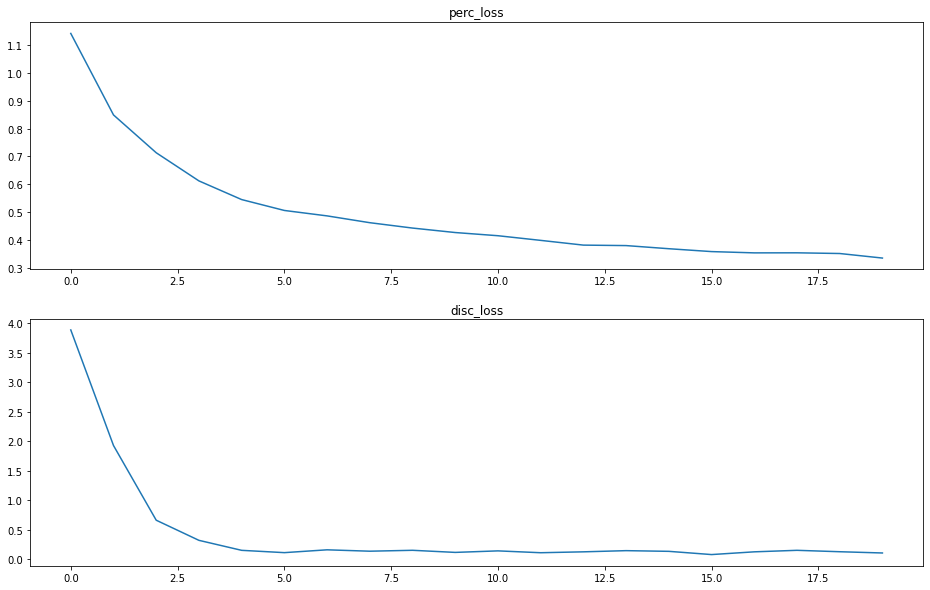

In [55]:
plot_results(history)

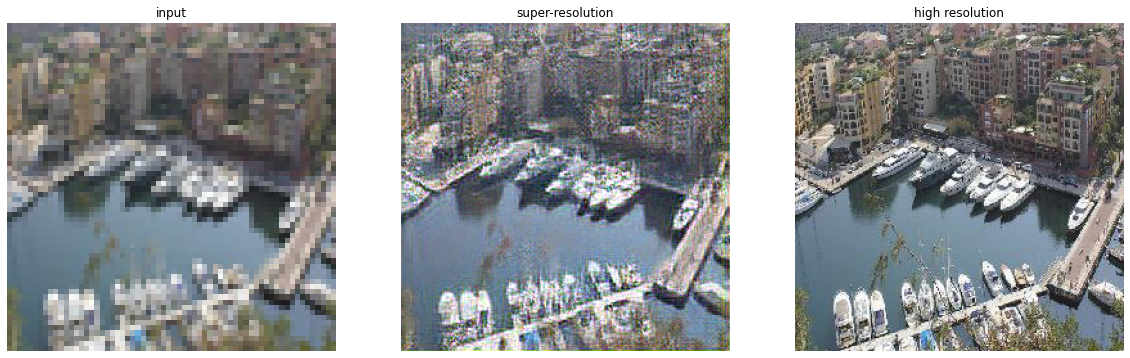

In [58]:
show_images(denormalize(X_test[5]), denormalize(Y_test[5]))

In [88]:
generator.save('generator')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [34]:
discriminator.save('discriminator')

In [46]:
%cd /kaggle/working

!zip -r input-models.zip generator discriminator

from IPython.display import FileLink
FileLink('input-models.zip')

/kaggle/working
  adding: generator/ (stored 0%)
  adding: generator/keras_metadata.pb (deflated 96%)
  adding: generator/assets/ (stored 0%)
  adding: generator/saved_model.pb (deflated 92%)
  adding: generator/variables/ (stored 0%)
  adding: generator/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: generator/variables/variables.index (deflated 80%)
  adding: discriminator/ (stored 0%)
  adding: discriminator/keras_metadata.pb (deflated 95%)
  adding: discriminator/assets/ (stored 0%)
  adding: discriminator/saved_model.pb (deflated 91%)
  adding: discriminator/variables/ (stored 0%)
  adding: discriminator/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: discriminator/variables/variables.index (deflated 65%)


/kaggle/working/input-models.zip